In [1]:
import gymnasium as gym
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
import torch 
import collections
import IPython
import random

In [2]:
class ReplayBuffer:
    """Fixed-size buffer to store experience tuples."""

    def __init__(self, action_size, buffer_size, batch_size, seed):
        """Initialize a ReplayBuffer object.

        Params
        ======
            action_size (int): dimension of each action
            buffer_size (int): maximum size of buffer
            batch_size (int): size of each training batch
            seed (int): random seed
        """
        self.action_size = action_size
        self.memory = collections.deque(maxlen=buffer_size)  
        self.batch_size = batch_size
        self.experience = collections.namedtuple("Experience", field_names=["state", "action", "reward", "next_state", "done"])
        self.seed = random.seed(seed)
    
    def add(self, state, action, reward, next_state, done):
        """Add a new experience to memory."""
        e = self.experience(state, action, reward, next_state, done)
        self.memory.append(e)
    
    def sample(self):
        """Randomly sample a batch of experiences from memory."""
        experiences = random.sample(self.memory, k=self.batch_size)
        
        # Convert to torch tensors
        states = torch.from_numpy(np.vstack([e.state for e in experiences if e is not None])).float().to(device)
        actions = torch.from_numpy(np.vstack([e.action for e in experiences if e is not None])).long().to(device)
        rewards = torch.from_numpy(np.vstack([e.reward for e in experiences if e is not None])).float().to(device)
        next_states = torch.from_numpy(np.vstack([e.next_state for e in experiences if e is not None])).float().to(device)
        
        # Convert done from boolean to int
        dones = torch.from_numpy(np.vstack([e.done for e in experiences if e is not None]).astype(np.uint8)).float().to(device)        
        
        return (states, actions, rewards, next_states, dones)

    def __len__(self):
        """Return the current size of internal memory."""
        return len(self.memory)

In [3]:
BUFFER_SIZE = 500*20   # replay buffer size
BATCH_SIZE = 128     # minibatch size
GAMMA = 0.99          # discount factor
#LR = 0.0001           # learning rate 
UPDATE_EVERY = 1

In [4]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device = "cpu"

In [5]:
env = gym.make('LunarLander-v2',render_mode='rgb_array')

In [6]:
net = torch.nn.Sequential(
    torch.nn.Linear(8,128), # 8은 state_size
    torch.nn.ReLU(),
    torch.nn.Linear(128,64),
    torch.nn.ReLU(),
    torch.nn.Linear(64,32),
    torch.nn.ReLU(),
    torch.nn.Linear(32,4)) # 4는 action_size 

In [7]:
optimizr = torch.optim.Adam(net.parameters(), lr=0.0001)

# 1 experience

`-` 

In [8]:
current_state, _ = env.reset()

In [9]:
current_state

array([ 0.00522375,  1.4137503 ,  0.52908695,  0.12577529, -0.00604615,
       -0.11984605,  0.        ,  0.        ], dtype=float32)

In [10]:
net(torch.tensor(current_state))

tensor([ 0.1732, -0.1231,  0.1577,  0.0593], grad_fn=<AddBackward0>)

In [11]:
_action1 = net(torch.tensor(current_state)).argmax().item()
_action1

0

In [12]:
_action2 = random.choice([0,1,2,3])
_action2 

0

In [13]:
act = lambda state, eps: net(torch.tensor(state)).argmax().item() if eps < random.random() else random.choice([0,1,2,3])

In [14]:
[act(current_state,0.95) for i in range(20)]

[0, 0, 2, 0, 1, 0, 0, 0, 0, 0, 3, 3, 1, 0, 0, 0, 2, 3, 3, 3]

In [15]:
[act(current_state,0.1) for i in range(20)]

[0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 2, 0, 0, 0, 0, 2, 0, 0, 0, 0]

In [16]:
action = act(current_state,0.05)

In [17]:
next_state, reward, terminated, truncated, info = env.step(action)

In [18]:
net(torch.tensor(next_state))

tensor([ 0.1735, -0.1236,  0.1591,  0.0605], grad_fn=<AddBackward0>)

In [19]:
reward

-1.125479665002614

In [20]:
qvalue_next_state = net(torch.tensor(next_state)).data.max().item()
qvalue_next_state

0.17352890968322754

In [21]:
reward + 0.99 * qvalue_next_state

-0.9536860444162187

In [22]:
qvalue_current_state = net(torch.tensor(current_state)).max()
qvalue_current_state

tensor(0.1732, grad_fn=<MaxBackward1>)

In [23]:
loss = torch.mean((qvalue_current_state - (reward + 0.99 * qvalue_next_state))**2)

In [24]:
loss.backward()

In [25]:
optimizr.step()

In [26]:
net(torch.tensor(current_state))

tensor([ 0.1704, -0.1238,  0.1563,  0.0592], grad_fn=<AddBackward0>)

## 코드정리 

### env $\to$ agent: current_state

In [78]:
current_state, _ = env.reset()
current_state

array([ 0.0059803 ,  1.4086145 ,  0.6057197 , -0.1024839 , -0.00692285,
       -0.13720453,  0.        ,  0.        ], dtype=float32)

### agent $\to$ env: action

In [79]:
act = lambda state, eps: net(torch.tensor(state)).argmax().item() if eps < random.random() else random.choice([0,1,2,3])

In [80]:
action = act(current_state,0.05)
action

1

### env $\to$ agent: reward,next_state

In [81]:
next_state, reward, terminated, truncated, info = env.step(action)

In [82]:
net(torch.tensor(next_state))

tensor([76.1099, 78.6500, 75.2146, 74.1214], grad_fn=<AddBackward0>)

In [83]:
reward

0.34873366803376027

### agent: update ($q$-value generating) network

In [99]:
qvalue_current_state = net(torch.tensor(current_state)).max()
qvalue_next_state = net(torch.tensor(next_state)).max().data
reward2 = reward + 0.99 * qvalue_next_state 
loss = torch.mean((qvalue_current_state - reward2)**2)

In [100]:
loss.backward()

In [101]:
optimizr.step()

## 코드정리 (리플레이버퍼사용)

In [143]:
current_state_history = collections.deque(maxlen=50000)
action_history = collections.deque(maxlen=50000)
next_state_history = collections.deque(maxlen=50000)
terminated_history = collections.deque(maxlen=50000)
reward_history = collections.deque(maxlen=50000)

### t=1

In [159]:
### env -> agent: current_state
current_state, _ = env.reset()
current_state_history.append(current_state)
current_state_history

### agent -> env: action
act = lambda state, eps: net(torch.tensor(state)).argmax().item() if eps < random.random() else random.choice([0,1,2,3])
action = act(current_state,1)
action_history.append(action)
action_history

### env -> agent: reward,next_state
next_state, reward, terminated, truncated, info = env.step(action)
next_state_history.append(next_state)
reward_history.append(reward)
terminated_history.append(terminated)

### t=2~500 정도까지 데이터를 쌓자

In [160]:
for _ in range(499):
    current_state = next_state ## 수정
    current_state_history.append(current_state)
    current_state_history
    
    ### agent -> env: action
    act = lambda state, eps: net(torch.tensor(state)).argmax().item() if eps < random.random() else random.choice([0,1,2,3])
    action = act(current_state,1)
    action_history.append(action)
    action_history
    
    ### env -> agent: reward,next_state
    next_state, reward, terminated, truncated, info = env.step(action)
    next_state_history.append(next_state)
    reward_history.append(reward)
    terminated_history.append(terminated)

### agent $\to$ env: action

In [145]:
act = lambda state, eps: net(torch.tensor(state)).argmax().item() if eps < random.random() else random.choice([0,1,2,3])

In [146]:
action = act(current_state,0.05)
action_history.append(action)
action_history

deque([1], maxlen=50000)

### env $\to$ agent: reward,next_state

In [147]:
next_state, reward, terminated, truncated, info = env.step(action)
next_state_history.append(next_state)
reward_history.append(reward)
terminated_history.append(terminated)

In [148]:
next_state_history

deque([array([ 0.00793524,  1.4058449 ,  0.39408597, -0.12582007, -0.00677203,
              -0.04251326,  0.        ,  0.        ], dtype=float32)],
      maxlen=50000)

In [154]:
net(torch.tensor(current_state_history))

tensor(64.5809, grad_fn=<MaxBackward1>)

### agent: update ($q$-value generating) network

In [84]:
qvalue_current_state = net(torch.tensor(current_state)).max()
qvalue_next_state = net(torch.tensor(next_state)).max().data
loss = torch.mean((qvalue_current_state - (reward + 0.99 * qvalue_next_state))**2)

In [85]:
loss.backward()

In [86]:
optimizr.step()

In [ ]:
##

In [27]:
class Agent():
    """Interacts with and learns from the environment."""

    def __init__(self, state_size, action_size, seed):
        """Initialize an Agent object.
        
        Params
        ======
            state_size (int): dimension of each state
            action_size (int): dimension of each action
            seed (int): random seed
        """
        self.state_size = state_size
        self.action_size = action_size

        # Q-Network
        self.network = net.to(device)
        self.optimizer = torch.optim.Adam(self.network.parameters(), lr=0.0001)

        # Replay memory
        self.memory = ReplayBuffer(action_size, BUFFER_SIZE, BATCH_SIZE, seed)
        # Initialize time step (for updating every UPDATE_EVERY steps)
        self.t_step = 0
    
    def step(self, state, action, reward, next_state, done):
        # Save experience in replay memory
        self.memory.add(state, action, reward, next_state, done)
        
        # Learn every UPDATE_EVERY time steps.
        self.t_step = (self.t_step + 1) % UPDATE_EVERY
        if self.t_step == 0:
            # If enough samples are available in memory, get random subset and learn
            if len(self.memory) > BATCH_SIZE:
                experiences = self.memory.sample()
                self.learn(experiences, GAMMA)

    def act(self, state, eps=0.):
        """Returns actions for given state as per current policy.
        
        Params
        ======
            state (array_like): current state
            eps (float): epsilon, for epsilon-greedy action selection
        """
        state = torch.from_numpy(state).float().unsqueeze(0).to(device)
        
        if random.random() > eps:
            return np.argmax(self.network(state).cpu().data.numpy())
        else:
            return random.choice(np.arange(self.action_size))
        

    def learn(self, experiences, gamma):
        """Update value parameters using given batch of experience tuples.

        Params
        ======
            experiences (Tuple[torch.Variable]): tuple of (s, a, r, s', done) tuples 
            gamma (float): discount factor
        """
        # Obtain random minibatch of tuples from D
        states, actions, rewards, next_states, dones = experiences

        ## Compute and minimize the loss
        ### Extract next maximum estimated value from target network
        q_targets_next = self.network(next_states).detach().max(1)[0].unsqueeze(1)
        q_targets = rewards + gamma * q_targets_next * (1 - dones)

        ### Calculate expected value from local network
        q_expected = self.network(states).gather(1, actions)
        
        loss = torch.mean((q_expected-q_targets)**2)
        
        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()

In [28]:
def dqn(n_episodes=2000, max_t=500, eps_start=1.0, eps_end=0.01, eps_decay=0.995):
    """Deep Q-Learning.
    
    Params
    ======
        n_episodes (int): maximum number of training episodes
        max_t (int): maximum number of timesteps per episode
        eps_start (float): starting value of epsilon, for epsilon-greedy action selection
        eps_end (float): minimum value of epsilon
        eps_decay (float): multiplicative factor (per episode) for decreasing epsilon
    """
    playtimes=[] 
    scores = []                        # list containing scores from each episode
    scores_window = collections.deque(maxlen=100)  # last 100 scores
    eps = eps_start                    # initialize epsilon
    for i_episode in range(1, n_episodes+1):
        state, _  = env.reset()
        score = 0
        for t in range(max_t):
            ## STEP1: 
            action = agent.act(state, eps)
            
            ## STEP2: 
            next_state, reward, done, _, _ = env.step(action)
            
            ## STEP3: 
            agent.step(state, action, reward, next_state, done)
            
            ## STEP4: 
            state = next_state
            
            ## STEP5: 
            score += reward
            
            if done:
                playtimes.append(t)
                break 
        scores_window.append(score)       # save most recent score
        scores.append(score)              # save most recent score
        eps = max(eps_end, eps_decay*eps) # decrease epsilon
        print('\rEpisode {}\tAverage Score: {:.2f}\tPlaytime: {:.2f}'.format(i_episode, np.mean(scores_window), np.mean(playtimes)), end="")
        if i_episode % 100 == 0:
            print('\rEpisode {}\tAverage Score: {:.2f}\tPlaytime: {:.2f}'.format(i_episode, np.mean(scores_window), np.mean(playtimes)))
            torch.save(agent.network.state_dict(), 'checkpoint.pth')
        if np.mean(scores_window)>=200.0:
            print('\nEnvironment solved in {:d} episodes!\tAverage Score: {:.2f}'.format(i_episode, np.mean(scores_window)))
            torch.save(agent.network.state_dict(), 'checkpoint.pth')
            break
    return scores

In [29]:
env.reset()

(array([-0.00718632,  1.4053063 , -0.7279153 , -0.24951982,  0.00833396,
         0.1648837 ,  0.        ,  0.        ], dtype=float32),
 {})

In [30]:
agent = Agent(state_size=8, action_size=4, seed=0)
scores = dqn(n_episodes=2000, max_t=500, eps_start=1.00, eps_end=0.05, eps_decay=0.995)

Episode 100	Average Score: -159.16	Playtime: 112.78
Episode 200	Average Score: -64.65	Playtime: 142.243
Episode 300	Average Score: 51.64	Playtime: 150.090
Episode 400	Average Score: 114.62	Playtime: 165.36
Episode 500	Average Score: 105.38	Playtime: 194.59
Episode 598	Average Score: 200.97	Playtime: 232.31
Environment solved in 598 episodes!	Average Score: 200.97


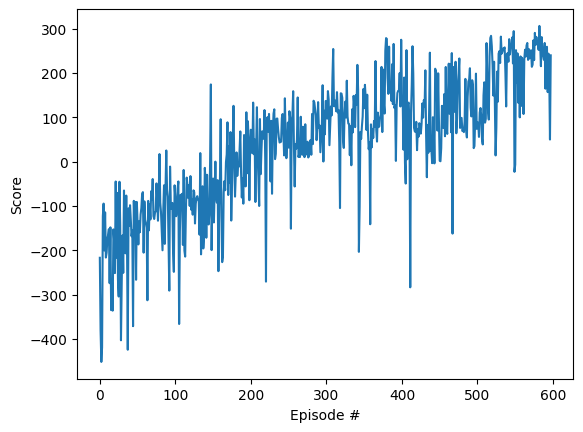

In [31]:
fig = plt.figure()
ax = fig.add_subplot(111)
plt.plot(np.arange(len(scores)), scores)
plt.ylabel('Score')
plt.xlabel('Episode #')
plt.show()

In [32]:
frames = []
agent = Agent(state_size=8, action_size=4, seed=0)
agent.network.load_state_dict(torch.load('checkpoint.pth'))
state,_ = env.reset()
done = False
while not done:
    frames.append(env.render())
    action = agent.act(state)
    state, reward, done, _,_ = env.step(action)
env.close()

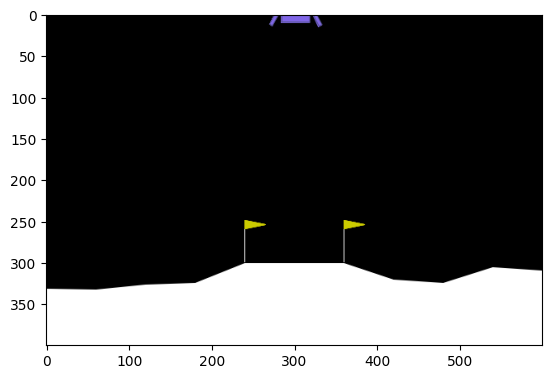

In [33]:
fig, ax = plt.subplots()
ani = FuncAnimation(fig,lambda i: ax.imshow(frames[::10][i]),frames=len(frames[::10]))

`-` 방법1

In [34]:
# ani.save('LunarLander-v2.mp4', writer='ffmpeg', fps=15, extra_args=['-vcodec', 'mpeg4'])

`-` 방법2

In [35]:
IPython.display.HTML(ani.to_jshtml())